<span style="font-size:3em;">Ch5: The Mechanics of Learning
</span>

# 5.1 A timeless lesson in modeling

 We can argue that learning from data presumes the underlying model is not engineered to solve a specific problem and is instead capable of approximating a much wider family of functions
 
  In this book, we’re interested in models that are not engineered for solving a specific narrow task, but that can be automatically adapted to specialize themselves for
any one of many similar tasks using input and output pairs—in other words, general
models trained on data relevant to the specific task at hand. In particular, PyTorch is
designed to make it easy to create models for which the derivatives of the fitting error,
with respect to the parameters, can be expressed analytically

 In this book, we’re interested in models that are not engineered for solving a specific narrow task, but that can be automatically adapted to specialize themselves for
any one of many similar tasks using input and output pairs—in other words, general
models trained on data relevant to the specific task at hand. In particular, PyTorch is
designed to make it easy to create models for which the derivatives of the fitting error,
with respect to the parameters, can be expressed analytically.  

In order to make sure we get the key concepts right, we’ll start with a model
that is a lot simpler than a deep neural network

# 5.2 Learning is just parameter estimation

Given input data and the corresponding desired outputs (ground truth), as
well as initial values for the weights, the model is fed input data (forward pass), and a
measure of the error is evaluated by comparing the resulting outputs to the ground
truth. In order to optimize the parameter of the model—its weights—the change in
the error following a unit change in weights (that is, the gradient of the error with
respect to the parameters) is computed using the chain rule for the derivative of a
composite function (backward pass). The value of the weights is then updated in the
direction that leads to a decrease in the error

When we start, we’ll be doing everything by hand,
but by the end of the chapter we’ll be letting PyTorch do all the heavy lifting for us.

In [4]:
import torch
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
#We will start by using temperature data 
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

tensor([ 0.5000, 14.0000, 15.0000, 28.0000, 11.0000,  8.0000,  3.0000, -4.0000,
         6.0000, 13.0000, 21.0000])

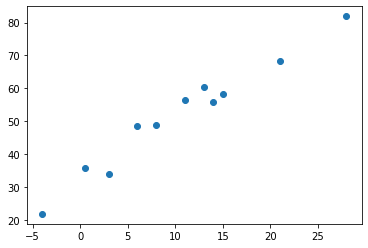

In [9]:
#quick 
plt.scatter(t_c,t_u)

 The
two may be linearly related—that is, multiplying t_u by a factor and adding a constant,
we may get the temperature in Celsius:
<b>t_c = w * t_u + b</b>

 Let’s flesh it out again: we have a model with some unknown parameters, and we
need to estimate those parameters so that the error between predicted outputs and
measured values is as low as possible. We notice that we still need to exactly define a
measure of the error. Such a measure, which we refer to as the loss function, should be
high if the error is high and should ideally be as low as possible for a perfect match.
Our optimization process should therefore aim at finding w and b so that the loss
function is at a minimum.


# 5.3 Less loss is what we want
A loss function (or cost function) is a function that computes a single numerical value
that the learning process will attempt to minimize. 

In our case,
that would be the difference between the predicted temperatures t_p output by our
model and the actual measurements: t_p – t

<b> Mean Squared Error</b> is a common loss function for regression.

MSE has a clear minimum at 0 and grows monotically as the prediction moves away from the true value in both directions. Because steepness of the growth also monotically increases away from the minimum, it is a <b>convex</b> function. Since our model is linear, the loss as a function of w and b are also convex


 Cases where the loss is a convex function of the model parameters are usually great to deal with because we can find a minimum very efficiently through specialized algorithms. However, we will instead use less powerful but more
generally applicable methods in this chapter. We do so because for the deep neural networks we are ultimately interested in, the loss is not a convex function of the inputs.

 For our two loss functions <b>|t_p – t_c| and (t_p – t_c)^2</b>, as shown in figure 5.4,
we notice that the square of the differences behaves more nicely around the minimum: the derivative of the error-squared loss with respect to t_p is zero when t_p
equals t_c. The absolute value, on the other hand, has an undefined derivative right
where we’d like to converge. This is less of an issue in practice than it looks like, but
we’ll stick to the square of differences for the time being.

## 5.3.1 From problem back to PyTorch

 Now we need to set the learning process in motion and feed it actual data. 
 We’ve already created our data tensors, so now let’s write out the model as a
Python function:

In [10]:
def model(t_u, w, b):
    return w * t_u + b

We’re expecting t_u, w, and b to be the input tensor, weight parameter, and bias
parameter, respectively. In our model, the parameters will be PyTorch scalars (aka zero-dimensional tensors), and the product operation will use broadcasting to yield
the returned tensors.

Now lets define loss:

In [12]:
def loss_fn(t_p,t_c):
    '''
    Mean Squared Loss
    '''
    squared_dffs = (t_p - t_c)**2
    return squared_dffs.mean()

In [51]:
#Now lets initialize w and b and create the model
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [52]:
#loss
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8846)

<b>Broadcasting:</b>


We mentioned broadcasting in chapter 3, and we promised to look at it more carefully
when we need it. In our example, we have two scalars (zero-dimensional tensors) w
and b, and we multiply them with and add them to vectors (one-dimensional tensors)
of length b.
Usually—and in early versions of PyTorch, too—we can only use element-wise binary
operations such as addition, subtraction, multiplication, and division for arguments
of the same shape. The entries in matching positions in each of the tensors will be
used to calculate the corresponding entry in the result tensor.


Broadcasting, which is popular in NumPy and adapted by PyTorch, relaxes this assumption for most binary operations. It uses the following rules to match tensor elements:
- For each index dimension, counted from the back, if one of the operands is
size 1 in that dimension, PyTorch will use the single entry along this dimension with each of the entries in the other tensor along this dimension.


- If both sizes are greater than 1, they must be the same, and natural matching
is used.


- If one of the tensors has more index dimensions than the other, the entirety
of the other tensor will be used for each entry along these dimensions.

This sounds complicated (and it can be error-prone if we don’t pay close attention, which
is why we have named the tensor dimensions as shown in section 3.4), but usually,
we can either write down the tensor dimensions to see what happens or picture what
happens by using space dimensions to show the broadcasting, as in the following figure.

<b>Note:</b> This is for element-wise multiplication below not matrix multiplication(dot product)

In [53]:
x = torch.ones(())
y = torch.ones(3,1)
z = torch.ones(1,3)
a = torch.ones(2,1,1)

print(f'shapes: x: {x.shape} y: {y.shape}')
print(f"z: {z.shape}, a: {a.shape}")

shapes: x: torch.Size([]) y: torch.Size([3, 1])
z: torch.Size([1, 3]), a: torch.Size([2, 1, 1])


In [54]:
print("x * y:", (x * y).shape)
print("y * z:", (y * z).shape)
print("y * z * a:", (y * z * a).shape)

x * y: torch.Size([3, 1])
y * z: torch.Size([3, 3])
y * z * a: torch.Size([2, 3, 3])


# 5.4 Down along the gradient

We’ll optimize the loss function with respect to the parameters using the gradient
descent algorithm.  Gradient descent is actually a very simple idea, and it scales up surprisingly well to large neural network models with millions of parameters.

## 5.4.1 Decreasing loss

The idea to to compute the rate of change of the loss with respect to each parameter, and modify each parameter in the direction of decreasing loss

In [69]:
delta = 0.1

#this backwards slash allows us to write on the next line, its called line continutation character
loss_rate_of_change_w = \
(loss_fn(model(t_u, w + delta, b), t_c) -
loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

In [70]:
loss_rate_of_change_w

tensor(4517.2979)

This is saying that in the neighborhood of the current values of w and b, a unit
increase in w leads to some change in the loss. If the change is negative, then we need
to increase w to minimize the loss, whereas if the change is positive, we need to
decrease w

It is also wise to
change the parameters slowly in general, because the rate of change could be dramatically different at a distance from the neighborhood of the current w value. Therefore,
we typically should scale the rate of change by a small factor. This scaling factor has
many names; the one we use in machine learning is <b>learning_rate</b>:

In [75]:
learning_rate = 1e-2

w = w - learning_rate* loss_rate_of_change_w

#Can do the same with b:
loss_rate_of_change_b = \
(loss_fn(model(t_u, w, b + delta), t_c) -
loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)

b=b- learning_rate * loss_rate_of_change_b

This represents the basic parameter-update step for gradient descent. By reiterating
these evaluations (and provided we choose a small enough learning rate), we will
converge to an optimal value of the parameters for which the loss computed on the
given data is minimal.

## 5.4.2 Getting analytical

In a model with two or more parameters like the one we’re
dealing with, we compute the individual derivatives of the loss with respect to each
parameter and put them in a vector of derivatives: the gradient.

In order to compute the derivative of the loss with respect to a parameter, we can
apply the chain rule and compute the derivative of the loss with respect to its input
(which is the output of the model), times the derivative of the model with respect to
the parameter:



dloss_fn / d w = (dloss_fn / d t_p) * (d t_p / d w)  


In [76]:
def loss_fn(t_p,t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

#Remembering that d x^2 / d x = 2 x, we get
def dloss_fn(t_p, t_c):
    dsg_diffs = 2 * (t_p - t_c) / t_p.size(0)
    return dsg_diffs

In [77]:
#Applying the derivatives to the model from earlier get
def dmodel_dw(t_u, w, b):
    return t_u
def dmodel_db(t_u,w,b):
    return 1.0

<b>DEFINING THE GRADIENT FUNCTION: </b>
Putting all of this together, the function returning the gradient of the loss with respect
to w and b is

In [79]:
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p,t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u,w,b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

## 5.4.3 Iterating to fit the model

We now have everything in place to optimize our parameters. Starting from a tentative
value for a parameter, we can iteratively apply updates to it for a fixed number of iterations, or until w and b stop changing. There are several stopping criteria; for now,
we’ll stick to a fixed number of iterations.

<b>THE TRAINING LOOP: </b>
Since we’re at it, let’s introduce another piece of terminology. We call a training iteration during which we update the parameters for all of our training samples an epoch.

In [80]:
#The complete training loop looks like this 
def training_loop(n_epochs, learning_rate, params, t_u, t_c, print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params
        t_p = model(t_u, w, b) # forward pass
        loss = loss_fn(t_p, t_c) 
        grad = grad_fn(t_u, t_c, t_p, w, b) # Backward pass
        
        params = params - learning_rate * grad
        
        print('Epoch %d, Loss %f' % (epoch, float(loss)))
        
    return params

In [85]:
#Here is a training loop that gives us more info for each epoch
def training_loop(n_epochs, learning_rate, params, t_u, t_c,
                  print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2>

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('\n    Params:', params)
                print('    Grad:  ', grad,'\n')
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break  # <3>
            
    return params

In [86]:
#Now lets train our model
training_loop(n_epochs=100,
             learning_rate=1e-2,
             params=torch.tensor([1.0,0.0]),
             t_u=t_u,
             t_c=t_c)

Epoch 1, Loss 1763.884644

    Params: tensor([-44.1730,  -0.8260])
    Grad:   tensor([4517.2969,   82.6000]) 

Epoch 2, Loss 5802485.500000

    Params: tensor([2568.4014,   45.1637])
    Grad:   tensor([-261257.4219,   -4598.9712]) 

Epoch 3, Loss 19408035840.000000

    Params: tensor([-148527.7344,   -2616.3933])
    Grad:   tensor([15109614.0000,   266155.7188]) 

...
Epoch 10, Loss 90901154706620645225508955521810432.000000

    Params: tensor([3.2144e+17, 5.6621e+15])
    Grad:   tensor([-3.2700e+19, -5.7600e+17]) 

Epoch 11, Loss inf

    Params: tensor([-1.8590e+19, -3.2746e+17])
    Grad:   tensor([1.8912e+21, 3.3313e+19]) 



tensor([-1.8590e+19, -3.2746e+17])

<b> OVERTRAINING: </b>  Wait, what happened? Our training process literally blew up, leading to losses becoming inf. This is a clear sign that params is receiving updates that are too large, and
their values start oscillating back and forth as each update overshoots and the next
overcorrects even more. The optimization process is unstable: it diverges instead of
converging to a minimum. We want to see smaller and smaller updates to params, not
larger

How can we limit the magnitude of learning_rate * grad? Well, that looks easy. We
could simply choose a smaller learning_rate, and indeed, the learning rate is one of
the things we typically change when training does not go as well as we would like.8
 
 We usually change learning rates by orders of magnitude, so we might try with 1e-3 or
1e-4, which would decrease the magnitude of the updates by orders of magnitude.
Let’s go with 1e-4 and see how it works out:

In [87]:
#again with lr=1e-4
training_loop(n_epochs=100,
             learning_rate=1e-4,
             params=torch.tensor([1.0,0.0]),
             t_u=t_u,
             t_c=t_c)

Epoch 1, Loss 1763.884644

    Params: tensor([ 0.5483, -0.0083])
    Grad:   tensor([4517.2969,   82.6000]) 

Epoch 2, Loss 323.090546

    Params: tensor([ 0.3623, -0.0118])
    Grad:   tensor([1859.5493,   35.7843]) 

Epoch 3, Loss 78.929634

    Params: tensor([ 0.2858, -0.0135])
    Grad:   tensor([765.4667,  16.5122]) 

...
Epoch 10, Loss 29.105242

    Params: tensor([ 0.2324, -0.0166])
    Grad:   tensor([1.4803, 3.0544]) 

Epoch 11, Loss 29.104168

    Params: tensor([ 0.2323, -0.0169])
    Grad:   tensor([0.5781, 3.0384]) 

...
Epoch 99, Loss 29.023582

    Params: tensor([ 0.2327, -0.0435])
    Grad:   tensor([-0.0533,  3.0226]) 

Epoch 100, Loss 29.022669

    Params: tensor([ 0.2327, -0.0438])
    Grad:   tensor([-0.0532,  3.0226]) 



tensor([ 0.2327, -0.0438])

Nice—the behavior is now stable. But there’s another problem: the updates to parameters are very small, so the loss decreases very slowly and eventually stalls. We could
obviate this issue by making learning_rate adaptive: that is, change according to the
magnitude of updates. There are optimization schemes that do that, and we’ll see one
toward the end of this chapter.


 However, there’s another potential troublemaker in the update term: the gradient
itself. Let’s go back and look at grad at epoch 1 during optimization. 

## 5.4.4 Normalizing inputs

We can see that the first-epoch gradient for the weight is about 50 times larger than
the gradient for the bias. This means the weight and bias live in differently scaled
spaces. If this is the case, a learning rate that’s large enough to meaningfully update
one will be so large as to be unstable for the other; and a rate that’s appropriate for
the other won’t be large enough to meaningfully change the first. That means we’re
not going to be able to update our parameters unless we change something about our
formulation of the problem. We could have individual learning rates for each parameter, but for models with many parameters, this would be too much to bother with


 There’s a simpler way to keep things in check: changing the inputs so that the gradients aren’t quite so different. We can make sure the range of the input doesn’t get
too far from the range of –1.0 to 1.0, roughly speaking.

In [88]:
#Lets try a simple fix by multiplying t_u by 0.1
t_un = 0.1 * t_u

training_loop(
n_epochs = 100,
learning_rate = 1e-2,
params = torch.tensor([1.0, 0.0]),
t_u = t_un,
t_c = t_c)

Epoch 1, Loss 80.364342

    Params: tensor([1.7761, 0.1064])
    Grad:   tensor([-77.6140, -10.6400]) 

Epoch 2, Loss 37.574917

    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864]) 

Epoch 3, Loss 30.871077

    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587]) 

...
Epoch 10, Loss 29.030487

    Params: tensor([ 2.3232, -0.0710])
    Grad:   tensor([-0.5355,  2.9295]) 

Epoch 11, Loss 28.941875

    Params: tensor([ 2.3284, -0.1003])
    Grad:   tensor([-0.5240,  2.9264]) 

...
Epoch 99, Loss 22.214186

    Params: tensor([ 2.7508, -2.4910])
    Grad:   tensor([-0.4453,  2.5208]) 

Epoch 100, Loss 22.148710

    Params: tensor([ 2.7553, -2.5162])
    Grad:   tensor([-0.4446,  2.5165]) 



tensor([ 2.7553, -2.5162])